# Dice Math

## Imports

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random

## Inits

In [24]:
# Trials
trials = 10000

# ATTACKER STATS
atk_dice = 4
hit_char = 3
norm_dam = 3
crit_dam = 4
lethal = 0
severe = False
rending = True
saturate = False
reroll_type = 0 # 0 is normal, 1 is balanced, 2 is ceaseless, 3 is relentless
accurate = 0
devastating = 0
piercing = 0

# DEFENDER STATS
opp_save = 3
opp_wounds = 14
cover_save = 1
jas = False
obscuring = False
defender_reroll = 0

## Functions

In [3]:
def reroll(roll_results: list[int],  hit_char: int, balanced: bool = False,
           ceaseless: bool = False, relentless: bool = False) -> list[int]:
    """
    Rerolls dice in different ways based on the type.

    Inputs:
        - roll_results: list[int], the list of the raw dice roll to be rerolled
        - hit_char: int, the hit characteristic as a threshold for rerolling
        - balanced: bool, rerolls one die of the lowest value
        - ceaseless: bool, rerolls all dice of one value, optimizes for value with the
                    most dice under threshold
        - relentless: bool, rerolls all dice under hit threshold

    Returns: list[int], the rerolled dice list
    """
    if balanced and min(roll_results) < hit_char:
        lowest = roll_results.index(min(roll_results))
        roll_results[lowest] = random.randint(1, 6)

    if ceaseless:
        result_dict = {}
        for result in roll_results:
            if result not in result_dict and result < hit_char:
                result_dict[result] = 1
            elif result in result_dict and result < hit_char:
                result_dict[result] += 1
            else:
                continue
        if result_dict:
            smallest_key_with_highest_value = max(result_dict.items(), key=lambda item: (item[1], -item[0]))[0]
            for idx, result in enumerate(roll_results):
                if result == smallest_key_with_highest_value:
                    roll_results[idx] = random.randint(1, 6)
            
    if relentless:
        for idx, result in enumerate(roll_results):
            if result < hit_char:
                roll_results[idx] = random.randint(1, 6)

    return roll_results

In [4]:
def run_dice_sim(atk_dice: int, hit_char: int, norm_dam: int, crit_dam: int, 
                 opp_save: int, lethal: int = 6, rending: bool = False, 
                 severe: bool = False, accurate: int = 0, devestating: int = 0, 
                 cover_save: int = 0, saturate: bool = False, piercing: int = 0, 
                 jas: bool = False, obscuring: bool = False, reroll_type: int = None,
                 defender_reroll: int = None) -> int:
    """
    Runs the attacker and defense dice at a basic level to obtain
    a damage output for a shooting attack.

    Inputs:
        - atk_dice: int, the number of attack dice
        - hit_char: int, the hit stat of the weapon
        - norm_dam: int, the normal damage stat of that weapon
        - crit_dam: int, the critical damage stat of that weapon
        - opp_save: int, the save characteristic of the opponent
        - lethal: int, crit threshold
        - accurate: int, autoretained hits
        - rending: bool, upgrades hit to crit if crit is retained
        - severe: bool, upgrades hit to crit if no crits
        - devastating: int, automatic damage from retaining crits
        - cover_save: int, automatic saves from cover
        - saturate: bool, gets rid of cover saves
        - piercing: int, limits the number of save dice
        - jas: bool, allows to negate a normal hit
        - obscuring: bool, downgrades all crits to hits, discards a hit
        - reroll_type: int, type of reroll
        - defender_reroll: int, type of reroll

    Returns: int, the amount of damage that goes through

    """
    dam_dict = {
        "Norm": norm_dam,
        "Crit": crit_dam,
        "Fail": 0
    }

    # Attacker Roll
    roll_results = []

    if accurate > 0: # Handles Accurate X
        atk_dice -= accurate
        for _ in range(accurate):
            roll_results.append(hit_char)

    for _ in range(atk_dice):
        roll = random.randint(1, 6)
        roll_results.append(roll)

    if reroll_type == 1:
        roll_results = reroll(roll_results, hit_char, balanced=True)
    if reroll_type == 2:
        roll_results = reroll(roll_results, hit_char, ceaseless=True)
    if reroll_type == 3:
        roll_results = reroll(roll_results, hit_char, relentless=True)

    hits = []
    for rr in roll_results:
        if rr >= lethal: # Handles Lethal X+
            hits.append("Crit")
        elif rr >= hit_char:
            hits.append("Norm")
        else:
            hits.append("Fail")

    if severe: # Handles Severe
        if "Crit" not in hits and "Norm" in hits:
            norm_idx = hits.index("Norm")
            hits[norm_idx] = "Crit"

    if rending: # Handles Rending
        if "Crit" in hits and "Norm" in hits:
            norm_idx = hits.index("Norm")
            hits[norm_idx] = "Crit"

    if obscuring: # Handles Obscuring, downgrades all Crits to Hits and removes a Hit
        for idx, hit in enumerate(hits):
            if hit == "Crit":
                hits[idx] = "Norm"
        hits.remove("Norm")
    
    dev = 0 # Handles Devestating
    if devestating > 0 and "Crit" in hits:
        for result in hits:
            if result == "Crit":
                dev += devestating

    # Defender Roll
    save_dice = 3
    save_roll_results = []

    if cover_save > 0: # Handles Cover Save
        save_dice -= cover_save
        for _ in range(cover_save):
            save_roll_results.append(opp_save)
    
    if saturate: # Handles Saturate
        save_roll_results = []
        save_dice = 3

    if piercing > 0: # Handles Piercing
        save_dice -= piercing

    for _ in range(save_dice):
        roll = random.randint(1, 6)
        save_roll_results.append(roll)

    if defender_reroll == 1:
        save_roll_results = reroll(save_roll_results, hit_char, balanced=True)
    if defender_reroll == 2:
        save_roll_results = reroll(save_roll_results, hit_char, ceaseless=True)
    if defender_reroll == 3:
        save_roll_results = reroll(save_roll_results, hit_char, relentless=True)
    
    saves = []
    for save in save_roll_results:
        if save == 6:
            saves.append("Crit")
        elif save >= opp_save:
            saves.append("Norm")
        else:
            saves.append("Fail")

    # Resolution of Crits
    for _ in range(saves.count("Crit")):
        if "Crit" in saves and "Crit" in hits:
            saves.remove("Crit")
            hits.remove("Crit")
        elif "Crit" in saves and "Norm" in hits:
            saves.remove("Crit")
            hits.remove("Norm")

    # Resolution of Normals
    for _ in range(saves.count("Norm")):
        if "Norm" in saves and "Norm" in hits:
            saves.remove("Norm")
            hits.remove("Norm")

    # Resolution of Crits with Normal Saves
    if "Crit" in hits and saves.count("Norm") >= 2:
        hits.remove("Crit")
        saves.remove("Norm")
        saves.remove("Norm")
    
    if "Norm" in hits and jas: # Handles JAS
        hits.remove("Norm")

    # Damage Resolution
    return (sum([dam_dict.get(item, item) for item in hits]) + dev)

In [9]:
def get_dice_stats(trials: int, opp_wounds: int):
    """
    Runs however many trials against an operative.
    """
    damage_list = []
    for _ in range(trials):
        damage_list.append(run_dice_sim(atk_dice, hit_char, norm_dam, crit_dam, 
                           opp_save, lethal, rending, severe, accurate, devastating,
                           cover_save, saturate, piercing, jas, obscuring, reroll_type,
                           defender_reroll))
    
    average_damage = np.average(damage_list)
    prob_to_wound = len([num for num in damage_list if num >= (opp_wounds/2)]
                        )/len(damage_list)
    prob_to_kill = len([num for num in damage_list if num >= opp_wounds]
                        )/len(damage_list)

    return (damage_list, average_damage, prob_to_wound, prob_to_kill)

## Simulate

Text(0.5, 0.5, 'Average Damage: 11.72\nProbability to Injure: 1.00\nProbability to Incapacitate: 0.12')

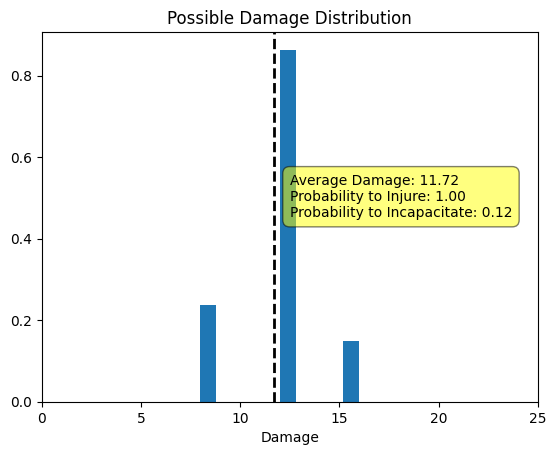

In [27]:
stats = get_dice_stats(trials, opp_wounds)
plt.hist(stats[0], density=True)
plt.xlim(0, 25)
plt.axvline(stats[1], color='black', linestyle='dashed', linewidth=2, label=f'Mean Damage: {stats[1]:.2f}')
plt.xlabel("Damage")
plt.title("Possible Damage Distribution")
plt.show

stats_text = f'Average Damage: {stats[1]:.2f}\nProbability to Injure: {stats[2]:.2f}\nProbability to Incapacitate: {stats[3]:.2f}'
plt.text(0.5, 0.5, stats_text, transform=plt.gca().transAxes,
         fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))